In [8]:
library(ggplot2)
library(dplyr)
library(viridis)
library(gridExtra)
library(Seurat)
library(data.table)
library(magrittr)
library(BandNorm)

gad_name="gad_score_10kb_filter2500.rds"
rna_name="Human_Multiple_Cortical_Areas_SMART-seq"
run_name="SMART_10kb_100k"

gene_min_len=100000

## Integration with scRNA-seq
in_path = "/scHiC/results/Ecker2019_scGAD/RDS/"
fig_path = "/scHiC/results/Ecker2019_scGAD/figures/"
rna_path = "/scHiC/data/scRNA-seq/"
in_hic_celltype_file = "/scHiC/data/Ecker2019/Ecker2019_summary_3DVI.txt"
in_gad_score_file = paste0(in_path, gad_name)

in_rna_celltype_file = paste0(rna_path, rna_name, "/metadata.csv") ##Human_Multiple_Cortical_Areas_SMART-seq
in_rna_count_file = paste0(rna_path, rna_name, "/matrix.csv") 

## 1. load GAD and scHi-C labels
print("1. Loading GAD...")
## gad_score 
gad_score = readRDS(in_gad_score_file)

## scHi-C cell type labels
schic_label = read.table(in_hic_celltype_file, header = TRUE)
summary = schic_label[match(colnames(gad_score), schic_label$name), ]



## 2. load RNA gene expression and labels
print("2. Loading RNA")
## cell type labels
celltypeRNA = fread(in_rna_celltype_file) %>% filter(outlier_call == FALSE)
## RNA raw count
RNA = fread(in_rna_count_file) %>% filter(sample_name %in% celltypeRNA$sample_name) #%>% data.frame
## convert into gene x cell matrix
gxc_RNA = t(RNA[, -1])
## add cell name
colnames(gxc_RNA) = celltypeRNA$sample_name


## 3. normalize and scale scRNA-seq data
print("3. Normalizing RNA...")
s = CreateSeuratObject(gxc_RNA)
s = NormalizeData(object = s, normalization.method = "LogNormalize", scale.factor = 1000000)
all.genes <- rownames(s)
s <- ScaleData(s, features = all.genes)

## 4. get the long genes
print("4. Get common genes...")
long_gene = hg19Annotations %>% mutate(len = s2 - s1) %>% filter(len >= gene_min_len) %$% gene_name
common_gene = rownames(s)[(rownames(s) %in% rownames(gad_score)) & (rownames(s) %in% long_gene)]
common_gene %>% length

## 5. add cell type to RNA seurat object and keep common genes
print("5. Create RNA seurat object...")
tmp = celltypeRNA$subclass_label
names(tmp) = celltypeRNA$sample_name
Idents(s) = paste0(tmp, "_RNA")
# all.genes <- rownames(s)
s$method = "scRNA-seq"
DefaultAssay(s) = "RNA"
RNA_filter_object = s[common_gene, ]

## 6. create seurat object for gad score and keep common genes
print("6. Create GAD seurat object...")
s = CreateSeuratObject(gad_score[common_gene, ])
s@assays$RNA@scale.data = gad_score[common_gene, ]
tmp = summary$cell_type
names(tmp) = summary$name
Idents(s) = paste0(tmp, "_GAD")
all.genes <- rownames(s)
s$method = "scGAD"
DefaultAssay(s) = "RNA"
scGAD_object = s

saveRDS(list(scGAD_object, RNA_filter_object, summary, celltypeRNA), file = paste0(in_path, run_name, "_immune.combine_long_gene_object_labels.rds"))


[1] "1. Loading GAD..."
[1] "2. Loading RNA"
[1] "3. Normalizing RNA..."


Centering and scaling data matrix



[1] "4. Get common genes..."


[1] 3289

[1] "5. Create RNA seurat object..."
[1] "6. Create GAD seurat object..."


correlation,schic_ct,rna_ct,method
<dbl>,<chr>,<chr>,<chr>
0.6330568442,Astro,Astro,Original
0.0002406523,Astro,Astro,Shuffled
0.5124146420,Endo,Endo,Original
-0.0370254615,Endo,Endo,Shuffled
0.5780443935,L23,L2/3 IT,Original
-0.0025904002,L23,L2/3 IT,Shuffled
0.5786736888,L5,L5 IT,Original
0.0047596120,L5,L5 IT,Shuffled
0.4556844366,L6,L6 CT,Original


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message:
“Removed 1 rows containing missing values (geom_bar).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_bar).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


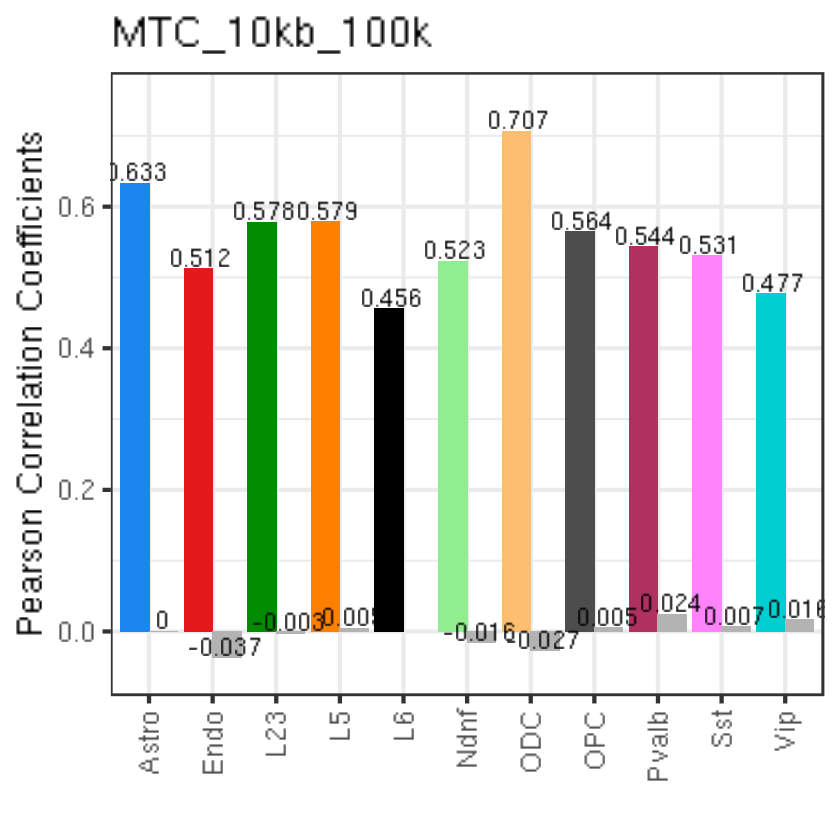

In [37]:
run_name="MTC_10kb_100k"
#run_name="SMART_10kb_100k"
tmp = readRDS(file = paste0(in_path, run_name, "_immune.combine_long_gene_object_labels.rds"))
scGAD_object = tmp[[1]]
RNA_filter_object = tmp[[2]]
summary = tmp[[3]]
celltypeRNA = tmp[[4]]

set.seed(2022)
celltypeRNA_shuffle = celltypeRNA
celltypeRNA_shuffle$subclass_label = celltypeRNA$subclass_label[sample(1:nrow(celltypeRNA), nrow(celltypeRNA), replace = F)]
summary_shuffle = summary
summary_shuffle$cell_type = summary$cell_type[sample(1:nrow(summary), nrow(summary), replace = FALSE)]

rna_label = celltypeRNA
schic_label = summary
rna_label_shuffle = celltypeRNA_shuffle
schic_label_shuffle = summary_shuffle

if(run_name == "MTC_10kb_100k"){
    schic_label_list = c("Astro", "Endo", "L23", "L5", "L6", "Ndnf", "ODC", "OPC", "Pvalb", "Sst", "Vip")
    rna_label_list = c("Astro","Endo", "L2/3 IT",  "L5 IT",  "L6 CT", "Lamp5", "Oligo", "OPC", "Pvalb", "Sst","Vip")

}else{
    schic_label_list = c("L6", "ODC", "OPC", "Sst", "Astro", "MP", "MG", "Ndnf", "Pvalb", "Vip", "Endo")
    rna_label_list = c("L6 CT", "Oligodendrocyte", "OPC", "SST",  "Astrocyte", "Microglia", "Microglia", "LAMP5", "PVALB",  "VIP",  "Endothelial")

}

rna_data = RNA_filter_object@assays$RNA@scale.data
schic_data = scGAD_object@assays$RNA@scale.data
correlation = c()
for(i in 1:length(schic_label_list)){

    schic_ind = which(schic_label$cell_type == schic_label_list[i])
    rna_ind = which(rna_label$subclass_label == rna_label_list[i])

    correlation = data.frame(
        correlation = cor(
            rna_data[, rna_label$sample_name[rna_ind]] %>% as.matrix %>% rowMeans, 
            schic_data[, schic_label$name[schic_ind]] %>% as.matrix %>% rowMeans
        ), 
        schic_ct = schic_label_list[i], 
        rna_ct = rna_label_list[i],
        method = "Original") %>% 
    rbind(correlation, .)

    schic_ind = which(schic_label_shuffle$cell_type == schic_label_list[i])
    rna_ind = which(rna_label_shuffle$subclass_label == rna_label_list[i])

    correlation = data.frame(
        correlation = cor(
            rna_data[, rna_label_shuffle$sample_name[rna_ind]] %>% as.matrix %>% rowMeans, 
            schic_data[, schic_label_shuffle$name[schic_ind]] %>% as.matrix %>% rowMeans
        ), 
        schic_ct = schic_label_list[i], 
        rna_ct = rna_label_list[i],
        method = "Shuffled") %>% 
    rbind(correlation, .)

}
saveRDS(correlation, file = paste0(in_path, run_name, "_correlation_per_celltype.rds"))
correlation

correlation %>% ggplot(aes(x = schic_ct, y = correlation, label = round(correlation, 3), fill = paste0(schic_ct, "_", method))) +
geom_bar(stat = "identity", position = position_dodge()) +
geom_text(size = 5, position = position_dodge(width = 0.8), vjust = -0.1) + 
theme_bw(base_size = 20) +
scale_fill_viridis(discrete = TRUE) +
xlab("") +
rremove("legend") +
rotate_x_text(angle = 90) +
scale_fill_manual(breaks = paste0(c("Astro", "Endo", "L23", "L4", 'L5', 'L6', 'MG', 'MP', 'Ndnf',
                    'ODC', 'OPC', 'Pvalb', 'Sst', 'Vip'), rep(c("_Original", "_Shuffled"), each = 14)),
                   values = c("dodgerblue2", "#E31A1C", "green4", "#6A3D9A", "#FF7F00",
         "black", "gold1", "skyblue2", "palegreen2", "#FDBF6F",
         "gray30", "maroon", "orchid1", "darkturquoise", 
         rep("grey70", 14))) +
         ylab("Pearson Correlation Coefficients") +
ggtitle(run_name) +
ylim(-0.05, 0.75)

ggsave(filename = paste0(fig_path, run_name, "_scGAD_scRNA_correlation_percelltype.pdf"), width = 11, height = 11)

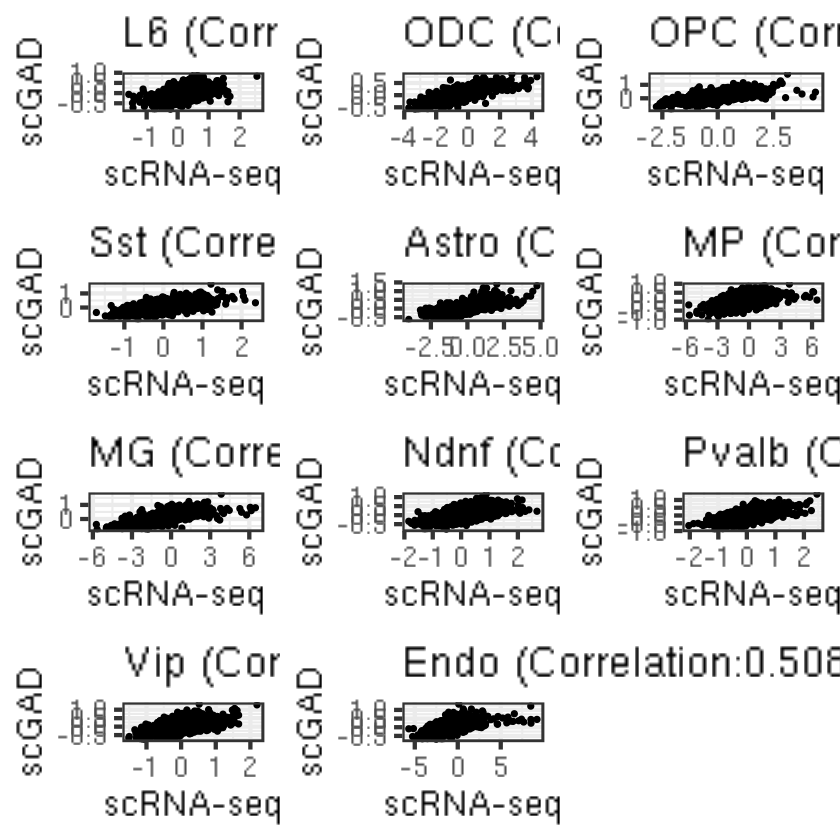

In [45]:
## run_name="MTC_10kb_100k"
run_name="SMART_10kb_100k"
tmp = readRDS(file = paste0(in_path, run_name, "_immune.combine_long_gene_object_labels.rds"))
scGAD_object = tmp[[1]]
RNA_filter_object = tmp[[2]]
summary = tmp[[3]]
celltypeRNA = tmp[[4]]

rna_label = celltypeRNA
schic_label = summary

if(run_name == "MTC_10kb_100k"){
    schic_label_list = c("Astro", "Endo", "L23", "L5", "L6", "Ndnf", "ODC", "OPC", "Pvalb", "Sst", "Vip")
    rna_label_list = c("Astro","Endo", "L2/3 IT",  "L5 IT",  "L6 CT", "Lamp5", "Oligo", "OPC", "Pvalb", "Sst","Vip")

}else{
    schic_label_list = c("L6", "ODC", "OPC", "Sst", "Astro", "MP", "MG", "Ndnf", "Pvalb", "Vip", "Endo")
    rna_label_list = c("L6 CT", "Oligodendrocyte", "OPC", "SST",  "Astrocyte", "Microglia", "Microglia", "LAMP5", "PVALB",  "VIP",  "Endothelial")

}

rna_data = RNA_filter_object@assays$RNA@scale.data
schic_data = scGAD_object@assays$RNA@scale.data
correlation = c()
fig_list = list()
for(i in 1:length(schic_label_list)){

    schic_ind = which(schic_label$cell_type == schic_label_list[i])
    rna_ind = which(rna_label$subclass_label == rna_label_list[i])

    correlation = cor(
            rna_data[, rna_label$sample_name[rna_ind]] %>% as.matrix %>% rowMeans, 
            schic_data[, schic_label$name[schic_ind]] %>% as.matrix %>% rowMeans
    ) %>% round(., 3)

    fig_list[[i]] = data.frame(x = rna_data[, rna_label$sample_name[rna_ind]]  %>% as.matrix %>% rowMeans, y = schic_data[, schic_label$name[schic_ind]] %>% as.matrix %>% rowMeans) %>% 
    ggplot(aes(x, y)) +
    geom_point(size = 1) +
    theme_bw(base_size = 20) +
    xlab("scRNA-seq") +
    ylab("scGAD") +
    ggtitle(paste0(schic_label_list[i], " (Correlation:", correlation, ")"))
}

ggarrange(fig_list[[1]], fig_list[[2]], fig_list[[3]], fig_list[[4]], fig_list[[5]], fig_list[[6]], fig_list[[7]],fig_list[[8]],fig_list[[9]],fig_list[[10]],fig_list[[11]],nrow = 4, ncol = 3)
ggsave(filename = paste0(fig_path, run_name, "_scGAD_scRNA_correlation_scatterplot.pdf"), width = 18, height = 23)